# Обучение GRU с Word2Vec (Бонус)

## Погрузка библиотек

In [1]:
import gc
import spacy
import pickle
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score, accuracy_score
from collections import Counter
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Подгрузка функций для обучения

In [3]:
from rnn_functions import ToxicDataset, collate_fn, plot_losses, train_and_validate, get_predictions, find_best_t, show_metrics

## Подготовка данных для обучения

In [4]:
df = pd.read_csv('modified_train.csv',usecols=['comment_text', 'toxicity_b', 'created_date'], parse_dates=['created_date'], date_format='ISO8601')
df = df[df['created_date'] >= '2016-04-01']
df = df.sort_values(by='created_date')[['comment_text', 'toxicity_b']].reset_index(drop=True)

In [5]:
import pickle

In [6]:
with open("tokens.pkl", "rb") as f:
    tokens = pickle.load(f)
    

In [32]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(
    sentences=tokens,
    vector_size=512,  # размерность эмбеддинга
    window=5,
    min_count=5,
    workers=6,
    sg=1  # Skip-gram
)

word2vec_model.save("word2vec.model")

In [33]:
embedding_dim = word2vec_model.vector_size
vocab = list(word2vec_model.wv.index_to_key)

# Слово → индекс
word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}  # +2 для <pad> и <unk>
word2idx["<pad>"] = 0
word2idx["<unk>"] = 1

# Создаем матрицу весов для Embedding слоя
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, idx in word2idx.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]
    elif word == "<unk>":
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [34]:
numericalized_texts = [
    torch.tensor([word2idx.get(token, word2idx["<unk>"]) for token in text])
    for text in tokens
]

In [35]:
labels = torch.tensor(df['toxicity_b'].values, dtype=torch.float32)

In [36]:
X_train, y_train = numericalized_texts[:1428245], labels[:1428245]
X_test, y_test = numericalized_texts[1428245:], labels[1428245:]
X_val, y_val = X_train[1142596:], y_train[1142596:]
X_train, y_train = X_train[:1142596], y_train[:1142596]

In [37]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=word2idx["<pad>"])
    return padded, torch.tensor(labels)

In [38]:
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)
test_dataset = ToxicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)
train_loader_test = DataLoader(train_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

## Обучение лучшей модели GRU с собственными эмбедингами Word2Vec

Здесь проводилось обучение только той модели, которая лучше всего себя показала с базовой токенизацией

In [39]:
def f1_metric(preds, targets):
    probs = torch.sigmoid(preds)
    preds_cls = (probs > 0.5).int().cpu().numpy()
    targets_cls = targets.int().cpu().numpy()
    return f1_score(targets_cls, preds_cls, average="binary", zero_division=0)

In [41]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=40734,
        embedding_size=512,
        hidden_size=256,
        num_classes=2,
        num_layers=1,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32),freeze=False)  # True, если хочешь заморозить веса)
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        last_hidden = hidden[-1]
        return self.linear(last_hidden).squeeze(1)

In [ ]:
model = GRUClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-6)
criterion = nn.BCEWithLogitsLoss()

train_f1, val_f1 = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_metric,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    verbose=True,
    save_path='GRUW2V_best.pth'
)

Было принято решение остановить обучение, так как по графику было видно, что модель начала сильно переобучаться
![GRU](images/OverT.png)

In [43]:
model.load_state_dict(torch.load('GRUW2V_best.pth'))

<All keys matched successfully>

GRUW2V Classifier

Precision		Recall			F1

Train: 0.74		Train: 0.73		Train: 0.73
Val: 0.70		Val: 0.69		Val: 0.69
Test: 0.70		Test: 0.69		Test: 0.70


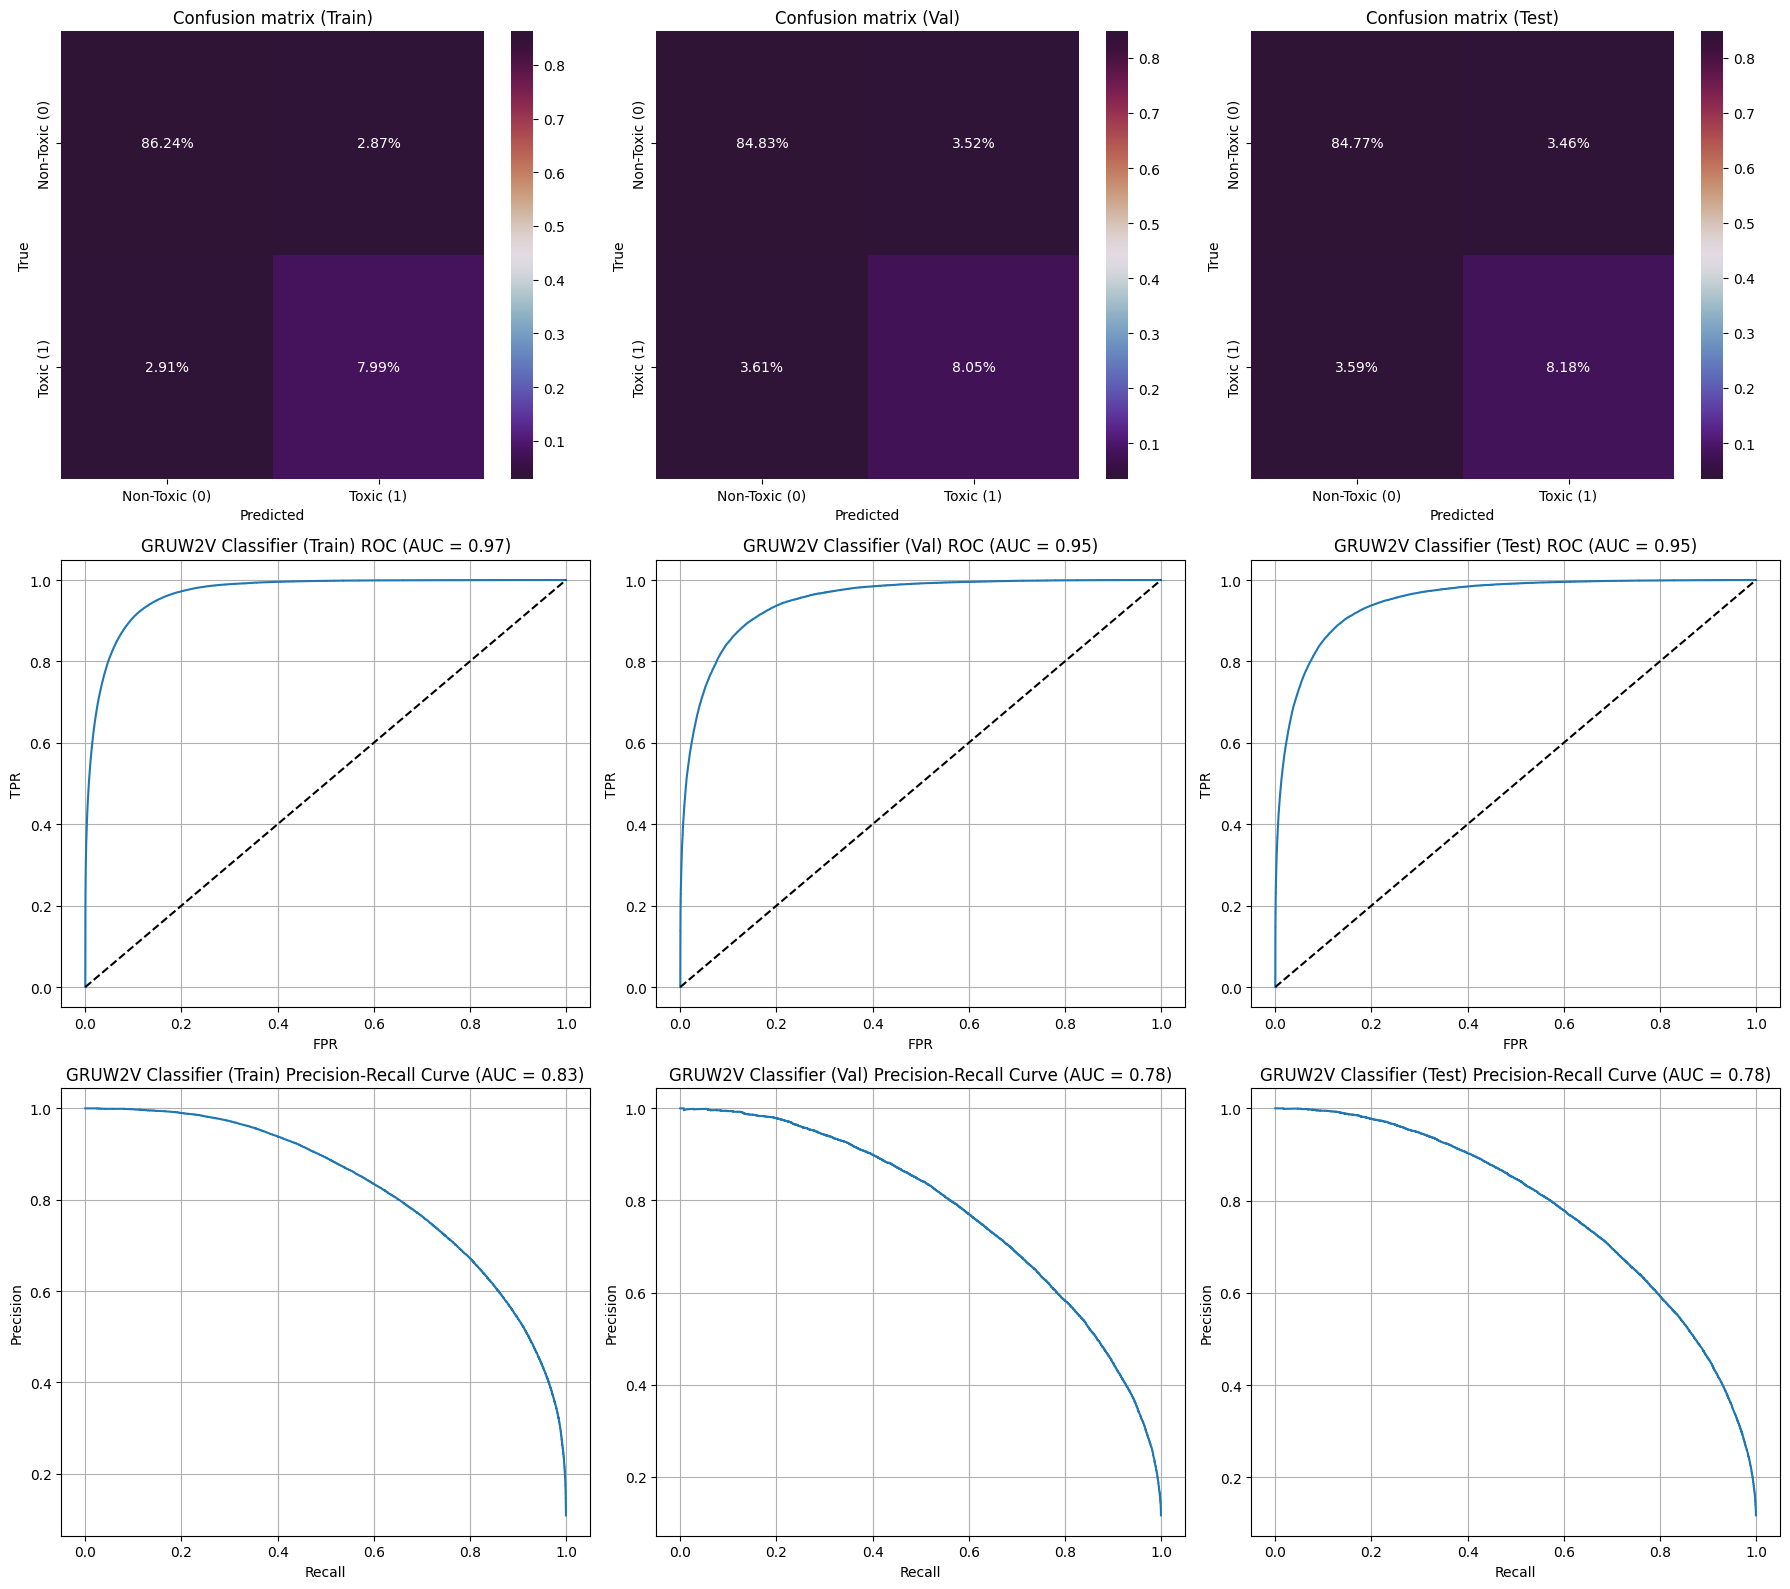

In [46]:
y_pred_proba_train = get_predictions(model, train_loader_test)
y_pred_proba_val = get_predictions(model, val_loader)
y_pred_proba_test = get_predictions(model, test_loader)

y_pred_train = (y_pred_proba_train > 0.39).astype(int)
y_pred_val = (y_pred_proba_val > 0.39).astype(int)
y_pred_test = (y_pred_proba_test > 0.39).astype(int)


show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_pred_train,
    y_pred_val=y_pred_val,
    y_pred_test=y_pred_test,
    y_pred_proba_train=y_pred_proba_train,
    y_pred_proba_val=y_pred_proba_val,
    y_pred_proba_test=y_pred_proba_test,
    title="GRUW2V Classifier"
)

In [45]:
find_best_t(y_pred_proba_val, y_val)

Лучший порог: 0.3900
Лучший F1: 0.6931


0.39